# Optimizer Testbed

#### This notebook tests optimization algorithms

Tasks
0. MNIST classification (CNN)
0. CIFAR-10 classification (CNN)
0. MNIST GAN?

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD']


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


## MNIST classification

Load data

In [2]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Build model:

In [3]:
def build_model(opt=keras.optimizers.Adadelta()):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


Train the model, plotting both train and test loss.

In [4]:
# First define a callback to record train and test loss on each minibatch
from keras.callbacks import Callback


class minibatch_History(Callback):
    """Callback that records events into a `History` object.
    
    Predicts over the validation set and each input batch (w/o dropout) 
    after each batch.

    """
    def __init__(self, count_mode='samples', Nevery = 1):
        super(minibatch_History, self).__init__()
        self.Nevery = Nevery
            
    
    def on_train_begin(self, logs=None):
        self.batch = []
        self.history = {'val_loss':list(),
                        'val_acc':list(),
                        'train_loss':list(),
                        'train_acc':list()}
        self.batch_no = 0
        self.target = self.params['samples']
        
    def on_batch_end(self, batch, logs=None):
        if self.batch_no % self.Nevery == 0 or self.batch_no == self.target:
            logs = logs or {}
            self.batch.append(batch)
            #print([np.array(l).shape for l in logs['input_batch']])
            for k, v in logs.items():
                if k is not 'input_batch':
                    self.history.setdefault(k, []).append(v)

            # add validation loss. Only test on a random subset of minibatch size
            val_loss, val_acc =  self.model.evaluate(self.validation_data[0], 
                                                     self.validation_data[1], verbose=0)   
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # add train loss
            train_loss, train_acc =  self.model.evaluate(logs['input_batch'][0], 
                                                     logs['input_batch'][1], verbose=0)   
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)


In [8]:
batch_size =128
epochs = 10
nb_train = 10000
nb_test = 1000

hist = minibatch_History(Nevery = 20)

model = build_model()

model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[hist])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
5s - loss: 0.8606 - acc: 0.7374 - val_loss: 0.3514 - val_acc: 0.8930
Epoch 2/10
5s - loss: 0.3013 - acc: 0.9108 - val_loss: 0.1957 - val_acc: 0.9430
Epoch 3/10
4s - loss: 0.2039 - acc: 0.9421 - val_loss: 0.1386 - val_acc: 0.9540
Epoch 4/10
4s - loss: 0.1637 - acc: 0.9544 - val_loss: 0.1228 - val_acc: 0.9560
Epoch 5/10
4s - loss: 0.1366 - acc: 0.9601 - val_loss: 0.1061 - val_acc: 0.9620
Epoch 6/10
4s - loss: 0.1187 - acc: 0.9634 - val_loss: 0.0881 - val_acc: 0.9630
Epoch 7/10
4s - loss: 0.1032 - acc: 0.9709 - val_loss: 0.1056 - val_acc: 0.9610
Epoch 8/10
4s - loss: 0.0911 - acc: 0.9732 - val_loss: 0.0808 - val_acc: 0.9690
Epoch 9/10
4s - loss: 0.0832 - acc: 0.9738 - val_loss: 0.0788 - val_acc: 0.9750
Epoch 10/10
4s - loss: 0.0743 - acc: 0.9779 - val_loss: 0.0746 - val_acc: 0.9720
Test loss: 0.0670692244784
Test accuracy: 0.9787


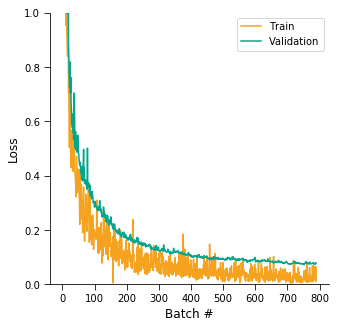

In [32]:
plt.figure(figsize=(5,5))
simpleaxis(plt.gca())

batch_no = np.arange(np.array(hist.history['loss']).shape[0])
plt.plot(batch_no,hist.history['train_loss'],color=colors[0])
plt.plot(batch_no,hist.history['val_loss'],color=colors[1])
plt.legend(['Train','Validation'],loc=0)
plt.xlabel('Batch #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.ylim((0,1));

Note that the the training loss is higher because it is calculated from the net in training, which has dropout instantiated. TODO change the callback so this prints the actual loss.

## Test GraVa

In [5]:
opt = keras.optimizers.GraVa(lr=0.001, beta_1=0.9, beta_2=0.999, var_care=1, decay=0.0)
gr_model = build_model(opt)

In [6]:
batch_size = 128
epochs = 10
nb_train = 10000
nb_test = 1000

gr_hist = minibatch_History(Nevery = 20)

gr_model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[gr_hist])
score = gr_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
4s - loss: 2.2999 - acc: 0.1253 - val_loss: 2.2896 - val_acc: 0.2180
Epoch 2/10
4s - loss: 2.2873 - acc: 0.1483 - val_loss: 2.2761 - val_acc: 0.2510
Epoch 3/10
4s - loss: 2.2715 - acc: 0.1864 - val_loss: 2.2617 - val_acc: 0.3060
Epoch 4/10
4s - loss: 2.2564 - acc: 0.2181 - val_loss: 2.2454 - val_acc: 0.3980
Epoch 5/10
4s - loss: 2.2408 - acc: 0.2574 - val_loss: 2.2260 - val_acc: 0.4690
Epoch 6/10
4s - loss: 2.2185 - acc: 0.2952 - val_loss: 2.2019 - val_acc: 0.5120
Epoch 7/10
4s - loss: 2.1939 - acc: 0.3418 - val_loss: 2.1720 - val_acc: 0.5570
Epoch 8/10
4s - loss: 2.1583 - acc: 0.3738 - val_loss: 2.1326 - val_acc: 0.5890
Epoch 9/10
4s - loss: 2.1129 - acc: 0.4126 - val_loss: 2.0799 - val_acc: 0.6120
Epoch 10/10
4s - loss: 2.0586 - acc: 0.4497 - val_loss: 2.0096 - val_acc: 0.6430
Test loss: 1.98553855743
Test accuracy: 0.6614


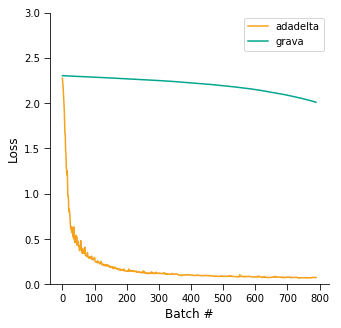

In [9]:
plt.figure(figsize=(5,5))
simpleaxis(plt.gca())

batch_no = np.arange(np.array(hist.history['loss']).shape[0])
plt.plot(batch_no,hist.history['val_loss'],color=colors[0])
plt.plot(batch_no,gr_hist.history['val_loss'],color=colors[1])
plt.legend(['adadelta','grava'],loc=0)
plt.xlabel('Batch #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.ylim((0,3));

#### Now optimize parameters to see if we can improve this horrid performance

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4rf = {
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'var_care': hp.loguniform('var_care', np.log(1e-1),np.log(1e1)), 
}

new_trials = Trials()

def fnc(params):
    lr = params['lr']
    var_care = params['var_care']
    
    
    gr_model = Sequential()
    gr_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    gr_model.add(Conv2D(64, (3, 3), activation='relu'))
    gr_model.add(MaxPooling2D(pool_size=(2, 2)))
    gr_model.add(Dropout(0.25))
    gr_model.add(Flatten())
    gr_model.add(Dense(128, activation='relu'))
    gr_model.add(Dropout(0.5))
    gr_model.add(Dense(num_classes, activation='softmax'))


    opt = keras.optimizers.GraVa(lr=lr, beta_1=0.99, beta_2=0.99, var_care=var_care, decay=0.0)
    gr_model.compile(loss=keras.losses.categorical_crossentropy,
                                   optimizer=opt,
                                      metrics=['accuracy'])
    
    gr_model.fit(x_train[:10000], y_train[:10000],
          batch_size=32,
          epochs=10,
          verbose=0,
          
          validation_data=(x_test[:1000], y_test[:1000]))
    score = gr_model.evaluate(x_test, y_test, verbose=0)
    print(score, params)
    return {'loss':score[0], 'status': STATUS_OK }

hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=50, trials=new_trials)

    

[0.3462504540205002, 0.90269999999999995] {'var_care': 0.1442885621915024, 'lr': 0.0011927333376094754}
[2.2598769653320314, 0.13830000000000001] {'var_care': 0.23068121166446615, 'lr': 4.020896093839936e-05}
[0.1532113124988973, 0.95330000000000004] {'var_care': 9.650850086415739, 'lr': 0.01248236199287573}
[2.1972593406677245, 0.47410000000000002] {'var_care': 3.3201139084382962, 'lr': 0.00014221133076272987}
[0.37374822305440902, 0.8992] {'var_care': 0.19856336552081763, 'lr': 0.0009069630839093318}
[0.086237596963287796, 0.97350000000000003] {'var_care': 0.10779026711367401, 'lr': 0.060475329946131993}
[1.3610071455001831, 0.75449999999999995] {'var_care': 2.8738387512294814, 'lr': 0.0003186747855827413}
[2.2894640548706056, 0.1424] {'var_care': 1.1858040211762895, 'lr': 1.6164504429082254e-05}
[0.083735498620569712, 0.97389999999999999] {'var_care': 6.123883804324175, 'lr': 0.043140418044194724}
[0.22925651353895665, 0.93379999999999996] {'var_care': 5.606430222983686, 'lr': 0.003

In [59]:
lrs, vcs, losses = zip(*[[trial['misc']['vals']['lr'][0], \
                    trial['misc']['vals']['var_care'][0], \
                    trial['result']['loss']] for trial in new_trials])
lrs = np.array(lrs)
vcs = np.array(vcs)
losses = np.array(losses)

In [63]:
[(losses[i], lrs[i], vcs[i]) for i in np.argsort(losses)];

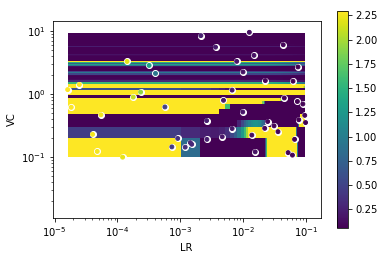

In [57]:
import scipy.interpolate


# Set up a regular grid of interpolation points
xi, yi = np.linspace(lrs.min(), lrs.max(), 100), np.linspace(vcs.min(), vcs.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
rbf = scipy.interpolate.Rbf(lrs, vcs, losses, function='gaussian')
zi = rbf(xi, yi)
plt.imshow(zi, vmin=losses.min(), vmax=losses.max(), origin='lower',
           extent=[lrs.min(), lrs.max(), vcs.min(), vcs.max()])
plt.scatter(lrs, vcs, c=losses,s=15,zorder = 2)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('LR')
plt.ylabel('VC')
plt.colorbar()
plt.scatter(lrs, vcs, c='w',zorder=1)
plt.show()

Now plot time course of best params. 

In [10]:



opt = keras.optimizers.GraVa(lr=0.072485440769771592, beta_1=0.99, beta_2=0.99, 
                             var_care=0.76771431639785814, decay=0.0)
gr_model = build_model(opt)

batch_size = 32
epochs = 10
nb_train = 10000
nb_test = 1000

gr_hist = minibatch_History(Nevery = 50)

gr_model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[gr_hist])



Train on 10000 samples, validate on 1000 samples
Epoch 1/10
11s - loss: 0.7230 - acc: 0.7698 - val_loss: 0.2580 - val_acc: 0.9160
Epoch 2/10
11s - loss: 0.2912 - acc: 0.9157 - val_loss: 0.2253 - val_acc: 0.9200
Epoch 3/10
11s - loss: 0.1996 - acc: 0.9396 - val_loss: 0.1159 - val_acc: 0.9610
Epoch 4/10
11s - loss: 0.1541 - acc: 0.9521 - val_loss: 0.0956 - val_acc: 0.9690
Epoch 5/10
11s - loss: 0.1278 - acc: 0.9597 - val_loss: 0.0927 - val_acc: 0.9720
Epoch 6/10
11s - loss: 0.1028 - acc: 0.9665 - val_loss: 0.1005 - val_acc: 0.9610
Epoch 7/10
11s - loss: 0.0914 - acc: 0.9705 - val_loss: 0.0806 - val_acc: 0.9750
Epoch 8/10
11s - loss: 0.0831 - acc: 0.9738 - val_loss: 0.0663 - val_acc: 0.9750
Epoch 9/10
11s - loss: 0.0730 - acc: 0.9763 - val_loss: 0.0668 - val_acc: 0.9760
Epoch 10/10
11s - loss: 0.0585 - acc: 0.9803 - val_loss: 0.0697 - val_acc: 0.9760


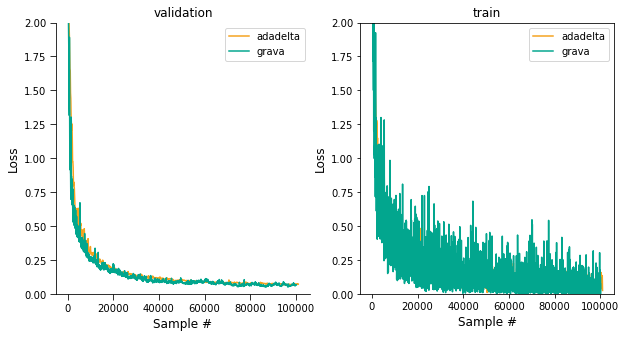

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(121)
simpleaxis(plt.gca())

batch_no = np.arange(np.array(hist.history['loss']).shape[0])*128
gr_batch_no = np.arange(np.array(gr_hist.history['loss']).shape[0])*32

plt.plot(batch_no,hist.history['val_loss'],color=colors[0])
plt.plot(gr_batch_no,gr_hist.history['val_loss'],color=colors[1])
plt.legend(['adadelta','grava'],loc=0)
plt.xlabel('Sample #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.title('validation')
plt.ylim((0,2));
plt.subplot(122)
plt.plot(batch_no,hist.history['loss'],color=colors[0])
plt.plot(gr_batch_no,gr_hist.history['loss'],color=colors[1])
plt.title('train')
plt.ylim((0,2));
plt.legend(['adadelta','grava'],loc=0)
plt.xlabel('Sample #',fontsize='large')
plt.ylabel('Loss',fontsize='large')

With whole data:

In [99]:
gr_model.fit(x_train, y_train,
      batch_size=32,
      epochs=10,
      verbose=0,
      validation_data=(x_test, y_test))
score = gr_model.evaluate(x_test, y_test, verbose=0)
print(score)
print('Error percent : %f'% (100.*(1.-score[1])))


[0.028708139271483968, 0.99170000000000003]
Error percent : 0.830000


Test other optimizers:

In [5]:
opt = keras.optimizers.GraVa(lr=0.072485440769771592, beta=0.99,  
                             var_care=0.76771431639785814, decay=0.0, momentum = 1)
gr_model = build_model(opt)

batch_size = 1
epochs = 10
nb_train = 10000
nb_test = 1000

gr_hist = minibatch_History(Nevery = 50)

gr_model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[gr_hist])
    

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
312s - loss: 2.0003 - acc: 0.3086 - val_loss: 2.3331 - val_acc: 0.0870
Epoch 2/10
316s - loss: 2.3180 - acc: 0.1010 - val_loss: 2.3386 - val_acc: 0.0870
Epoch 3/10
357s - loss: 2.3187 - acc: 0.1005 - val_loss: 2.3171 - val_acc: 0.0940
Epoch 4/10
335s - loss: 2.3180 - acc: 0.1062 - val_loss: 2.3089 - val_acc: 0.1260
Epoch 5/10
317s - loss: 2.3155 - acc: 0.1064 - val_loss: 2.3128 - val_acc: 0.0850
Epoch 6/10
317s - loss: 2.3160 - acc: 0.1039 - val_loss: 2.3000 - val_acc: 0.1160
Epoch 7/10
316s - loss: 2.3170 - acc: 0.1051 - val_loss: 2.3141 - val_acc: 0.0990
Epoch 8/10
310s - loss: 2.3184 - acc: 0.1031 - val_loss: 2.3180 - val_acc: 0.1100
Epoch 9/10
309s - loss: 2.3188 - acc: 0.0994 - val_loss: 2.3060 - val_acc: 0.1070
Epoch 10/10
309s - loss: 2.3178 - acc: 0.1040 - val_loss: 2.3187 - val_acc: 0.1070


### Test GDAM

In [5]:
opt = keras.optimizers.GDAM()
gdam = build_model(opt)

In [6]:
batch_size = 32
epochs = 10
nb_train = 10000
nb_test = 1000

gdam_hist = minibatch_History(Nevery = 50)

gdam.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          
          validation_data=(x_test[:nb_test], y_test[:nb_test]),
          callbacks=[gdam_hist])

TypeError: Join() can only join tensors with the same number of dimensions.

## Plot computational graphs

Train a simple 2 layer linear net on a simple problem. Print the computation graph to error check.

We'll be using TensorBoard, since it's awesome. This will print the log file for tensorboard; to see the graph and metrics you'll have to open the log in standalone tensorboard.

Note that this requires us to be using tf as the backend.

In [9]:
# function: z = exp(-x^2 -y^2)

x = np.random.normal(size = (1000,2))
z = np.exp(-x[:,1]**2 -x[:,0]**2)

x_test = np.random.normal(size = (100,2))
z_test = np.exp(-x_test[:,1]**2 -x_test[:,0]**2)


In [10]:
small_model = Sequential()

small_model.add(Dense(2, activation='linear',input_shape=(2,)))
small_model.add(Dense(1, activation='linear'))

opt = keras.optimizers.SGD()
small_model.compile(loss=keras.losses.mean_squared_error,
              optimizer=opt)


In [11]:
# for tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

small_model.fit(x,z,
          batch_size=10,
          epochs=10,
          verbose=0,
          validation_data=(x_test, z_test),
          callbacks=[tbCallBack])

RuntimeError: TensorBoard callback only works with the TensorFlow backend.

In [ ]:
# x = np.array([[[1,2], [2,2]], [[3,2], [4,2]]])
# y = np.array([[[5,2], [6,2]], [[7,2], [8,2]]])

x = np.ones((30,2,3))
y = x

print(np.sum(np.multiply(x,y)))

x = K.constant(x)
y = K.constant(y)

K.eval(K.sum(keras.backend.batch_dot(x,y,axes=(0,9)),axis=0))

In [ ]:
x = np.array([[1, 2], [3, 4]])
y = np.array([[5, 6], [7, 8]])

np.sum(np.multiply(x,y))

## Plot gradients
#### As a function of inputs, and as a function of batch/epoch